In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm

/Users/joyliu/anaconda3/envs/compsci371/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [7]:
df = pd.read_csv('3artist.csv')
df.head()
df['tokens'] = df['clean_lyrics'].apply(lambda x: x.split())

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

100%|██████████| 180/180 [00:05<00:00, 31.79it/s]


Logistic Regression Evaluation
Accuracy: 0.817
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.80      0.67      0.73        60
       Drake       0.89      0.95      0.92        60
Taylor Swift       0.76      0.83      0.79        60

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.81       180
weighted avg       0.82      0.82      0.81       180



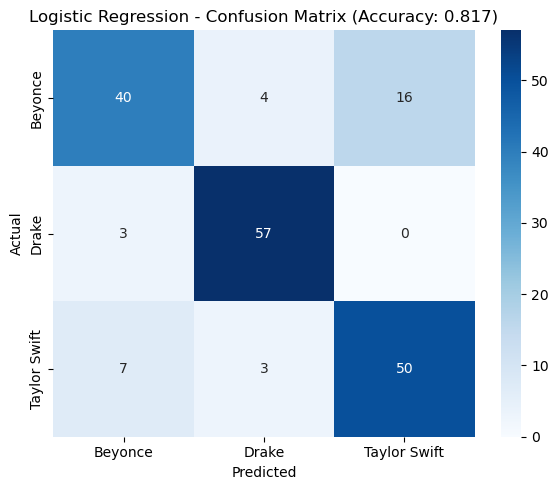

SVM Evaluation
Accuracy: 0.822
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.78      0.75      0.76        60
       Drake       0.90      0.92      0.91        60
Taylor Swift       0.79      0.80      0.79        60

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180



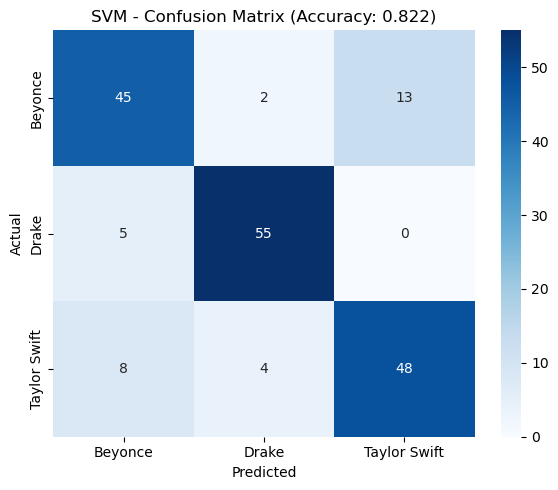

Random Forest Evaluation
Accuracy: 0.8
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.73      0.67      0.70        60
       Drake       0.98      0.95      0.97        60
Taylor Swift       0.70      0.78      0.74        60

    accuracy                           0.80       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.80      0.80      0.80       180



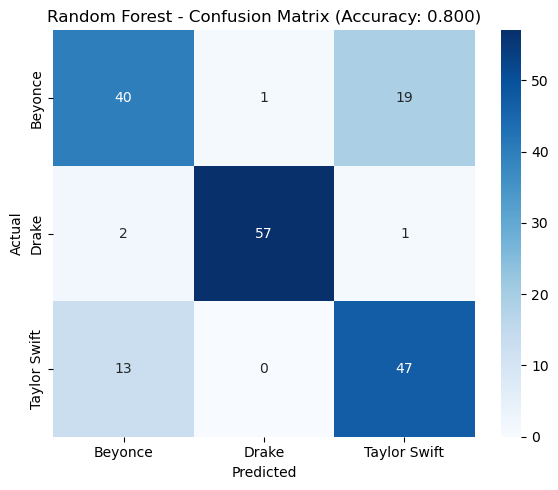

Naive Bayes Evaluation
Accuracy: 0.733
Classification Report:
               precision    recall  f1-score   support

     Beyonce       0.67      0.48      0.56        60
       Drake       0.84      0.90      0.87        60
Taylor Swift       0.67      0.82      0.74        60

    accuracy                           0.73       180
   macro avg       0.73      0.73      0.72       180
weighted avg       0.73      0.73      0.72       180



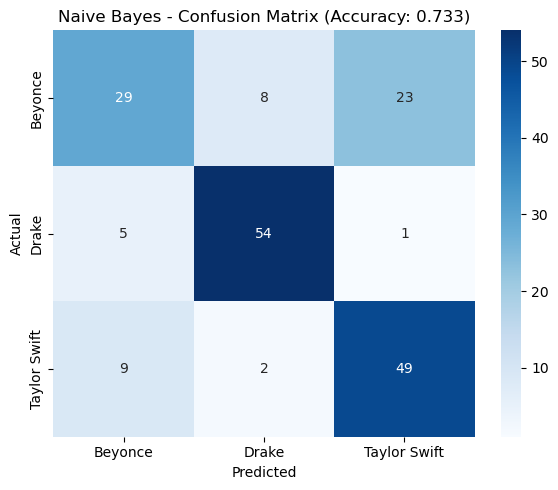

In [11]:
def get_bert_embeddings(texts, tokenizer, model, max_length=128):
    embeddings = []
    for text in tqdm(texts):
        encoded_input = tokenizer(text, padding='max_length', truncation=True,
                                  max_length=max_length, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        cls_embedding = output.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)


le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_lyrics'], df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

X_train_vec = get_bert_embeddings(X_train_text.tolist(), tokenizer, bert_model)
X_test_vec = get_bert_embeddings(X_test_text.tolist(), tokenizer, bert_model)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}



for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Evaluation")
    print("Accuracy:", round(acc, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Matplotlib + Seaborn confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix (Accuracy: {acc:.3f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()